<a href="https://colab.research.google.com/github/drew0523/MIR-Music_Information_Retrieval/blob/main/notebooks/4th_week_genre_classification.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Genre Classification with GTZAN dataset

In [1]:
!pip install --upgrade gdown
!gdown 1-4elQY1C-n23u3QqomnLiI9CN9iPrWC3
!tar -xzf genres.tar.gz


Downloading...
From (original): https://drive.google.com/uc?id=1-4elQY1C-n23u3QqomnLiI9CN9iPrWC3
From (redirected): https://drive.google.com/uc?id=1-4elQY1C-n23u3QqomnLiI9CN9iPrWC3&confirm=t&uuid=79e11c8b-6db7-4826-b4fc-60b7d8da7fe3
To: /content/genres.tar.gz
100% 1.23G/1.23G [00:09<00:00, 135MB/s]


In [9]:
# Navigate dataset
from pathlib import Path

data_dir = Path('genres/')
assert data_dir.exists()

# find every audio file

# use recursive glob to find wav file of every subdirectories: rglob
wav_fns = list(data_dir.rglob('*.wav'))
len(wav_fns)

# Caution: rglob order is rather chaotic
wav_fns[:10]

# Let's sort it
wav_fns.sort()

wav_fns[:10]

[PosixPath('genres/blues/blues.00000.wav'),
 PosixPath('genres/blues/blues.00001.wav'),
 PosixPath('genres/blues/blues.00002.wav'),
 PosixPath('genres/blues/blues.00003.wav'),
 PosixPath('genres/blues/blues.00004.wav'),
 PosixPath('genres/blues/blues.00005.wav'),
 PosixPath('genres/blues/blues.00006.wav'),
 PosixPath('genres/blues/blues.00007.wav'),
 PosixPath('genres/blues/blues.00008.wav'),
 PosixPath('genres/blues/blues.00009.wav')]

In [12]:
# Load audio
import torchaudio
import IPython.display as ipd

idx = 100
y, sr = torchaudio.load(wav_fns[idx])
print(y.shape, sr, wav_fns[idx])

ipd.Audio(y/5, rate = sr, normalize=False)

torch.Size([1, 661794]) 22050


Make Dataset Class
- __len__ : 데이터셋 안에 존재하는 데이터 샘플 개수
- __getitem__ : 데이터셋에서 idx 번쨰 데이터 샘플 반환

In [80]:
import random

class Dataset:
  def __init__(self, data_dir:str, slice_sec=3, sr=sr):
    self.data_dir = Path(data_dir)
    assert self.data_dir.exists()
    assert self.data_dir.is_dir()

    self.wave_fns = sorted(list(self.data_dir.rglob('*.wav')))

    # get unique cateogory_names
    entire_names = [wav_fn.parent.name for wav_fn in self.wave_fns]
    # unique_names = list(set(entire_names))
    # print(unique_names)
    self.catg_names = sorted(list(set(entire_names)))
    self.slice_sec = slice_sec
    self.sr = sr

  def load_audio(self):
    audios = []
    for wav_fn in self.wave_fns:
      audio, sr = torchaudio.load(wav_fn)
      if sr != self.sr:
        audio = torchaudio.functional.resample(audio, original_freq=sr, new_freq=self.sr)
      audios.append(audio)
    return audios


  def __len__(self):
    return len(self.wave_fns)

  def __getitem__(self, idx):
    # dataset[idx]를 할때 반환되는 값

    #audio, category 반환
    # audio, sr = torchaudio.load(self.wave_fns[idx])
    # if sr != self.sr:
    #   audio = torchaudio.functional.resample(audio, original_freq=sr, new_freq=self.sr)

    audio = self.audios[idx]

    slice_len = self.slice_sec * self.sr
    audio_len = audio.shape[1]
    last_start_point = audio_len - slice_len
    audio_start = int(random.random() * last_start_point) # 0-1

    audio = audio[:,audio_start:audio_start + slice_len]

    #category
    category_name = self.wave_fns[idx].parent.name
    category_idx = self.catg_names.index(category_name)

    return audio, category_idx



dataset = Dataset('genres')


wave_fn = dataset.wave_fns[0]
print(wave_fn)
print(len(dataset))
# print(dataset[0])

audio, category_idx = dataset[500]
ipd.Audio(audio, rate=dataset.sr, normalize = False)


genres/blues/blues.00000.wav
1000


In [45]:
# PosixPath의 attribute, method 들
print(wave_fn)
print(f"name is {wave_fn.name}")
print(f"stem is {wave_fn.stem}")
print(f"suffix is {wave_fn.with_suffix('.sep.wav')}") # PosixPath
print(f"parent is {wave_fn.parent}") # PosixPath
print(f"parent.name is {wave_fn.parent.name}") # str
print(f"absolute is {wave_fn.absolute()}") #PosixPath
print(f"relative_to is {wave_fn.relative_to('genres')}")

genres/blues/blues.00000.wav
name is blues.00000.wav
stem is blues.00000
suffix is genres/blues/blues.00000.sep.wav
parent is genres/blues
parent.name is blues
absolute is /content/genres/blues/blues.00000.wav
relative_to is blues/blues.00000.wav


In [46]:
pwd

'/content'

In [70]:
def custom_collate_fn(raw_batch):
  audios = [x[0] for x in raw_batch] # list of torch.Tensor
  labels = [x[1] for x in raw_batch] # list of int

  audios = torch.stack(audios)  # stack List of torch.Tensor
  labels = torch.LongTensor(labels) #

  return audios, labels

# collate_fn 의 입력은 무엇인가
raw_batch = [dataset[idx] for idx in range(32)]


In [116]:
import torch

data_loader = torch.utils.data.DataLoader(dataset,
                                          batch_size = 32,
                                          shuffle = True,
                                          collate_fn = custom_collate_fn)
# )
for batch in data_loader:
  # print(batch)
  # break
  # batch = next(iter(batch))
  audios, labels = batch
  break


In [118]:
audios.shape

torch.Size([32, 1, 66150])

Make Model

In [117]:
import torch.nn as nn

class Model(nn.Module):
  def __init__(self, out_dim= 10):
    super().__init__()
    self.mel = torchaudio.transforms.MelSpectrogram(sample_rate = 16000,
                                                    n_fft = 2048,
                                                    hop_length=1024,
                                                    n_mels=80
                                                    )
    self.db = torchaudio.transforms.AmplitudeToDB()
    self.linear = nn.Linear(80,32)
    self.linear2 = nn.Linear(32,32)
    self.linear3 = nn.Linear(32*65, 32)
    self.final_proj = nn.Linear(32,out_dim)

  def forward(self, x): #nn.Module은 __call__을 하면 forward로 연결됨
    if x.ndim ==3:
      x = x.squeeze(1) # This will delete dim = 1 if dim=1 has size 1
      # print(x.shape)
    x = self.mel(x) # Batch_size x Mel_bin x Time_Frame
    x = self.db(x) / 80
    x = x.transpose(1,2) # Batch_size x Time_Frame x Mel_bin
    x = self.linear(x) # Batch_szie x Time_Frame x Linear_Out
    x = x.relu()
    x = self.linear2(x)
    x = x.flatten(1,2) # flatten from dim = 1 to dim = 2: Batch_size x (Time_Frame x Linear_out)
    x = x.relu()
    x = self.linear3(x) # Batch_size x Linear_dim
    x = x.relu()
    x = self.final_proj(x)
    return x.softmax(dim=-1)

model = Model()
out = model(audios)
out.shape
out

tensor([[0.1069, 0.0922, 0.1135, 0.1000, 0.1013, 0.0802, 0.1071, 0.0899, 0.0991,
         0.1099],
        [0.1051, 0.0921, 0.1139, 0.1001, 0.1016, 0.0804, 0.1069, 0.0908, 0.0980,
         0.1112],
        [0.1058, 0.0926, 0.1130, 0.1006, 0.1013, 0.0812, 0.1062, 0.0905, 0.0974,
         0.1114],
        [0.1049, 0.0920, 0.1142, 0.1001, 0.1005, 0.0807, 0.1074, 0.0911, 0.0982,
         0.1110],
        [0.1073, 0.0917, 0.1145, 0.1007, 0.1013, 0.0795, 0.1055, 0.0895, 0.0997,
         0.1103],
        [0.1065, 0.0921, 0.1142, 0.0993, 0.1018, 0.0807, 0.1058, 0.0900, 0.0983,
         0.1112],
        [0.1062, 0.0920, 0.1138, 0.1002, 0.1014, 0.0800, 0.1065, 0.0909, 0.0982,
         0.1109],
        [0.1080, 0.0914, 0.1154, 0.1034, 0.1023, 0.0784, 0.1042, 0.0879, 0.0990,
         0.1099],
        [0.1077, 0.0919, 0.1146, 0.1013, 0.1016, 0.0789, 0.1061, 0.0883, 0.0996,
         0.1100],
        [0.1072, 0.0912, 0.1148, 0.1007, 0.1006, 0.0796, 0.1064, 0.0902, 0.0983,
         0.1109],
        [0

In [114]:
out[17,2] # probabilty of 17th sample belong to 2nd category

tensor(0.1104, grad_fn=<SelectBackward0>)

Make Training Loop

In [126]:
# train_set, test_set = torch.utils.data.random_split(data_loader, )

TypeError: 'float' object is not iterable

In [122]:
from tqdm.auto import tqdm

DEV = 'cuda'

model = Model()
optimizer = torch.optim.Adam(model.parameters())
model.to(DEV)
loss_records = []

# batch = next(iter(data_loader))
# audios, labels = batch

for batch in tqdm(data_loader):
  audios, labels = batch
# for _ in range(100):
  prob = model(audios.to(DEV))
  #negative log likelihood
  prob_of_correct_class = prob[torch.arange(len(prob)), labels]
  # prob_of_correct_class
  nll = -torch.log(prob_of_correct_class + 1e-8)
  loss = nll.mean() # 32개의 nll
  loss.backward() # backpropagation: Make gradient for each parameters
  optimizer.step() # update parameter
  optimizer.zero_grad() # reset gradient
  loss_records.append(loss.item())

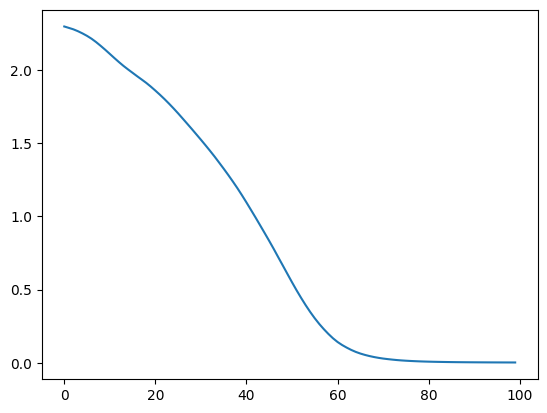

In [123]:
plt.plot(loss_records)

In [106]:
torch.max(out[0])

tensor(0.3728)

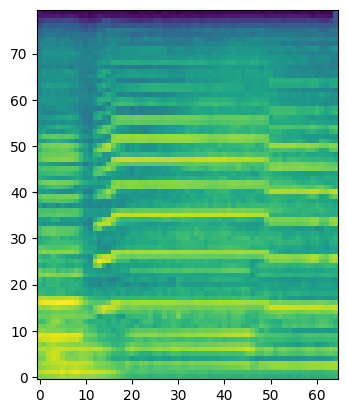

In [107]:
import matplotlib.pyplot as plt
# plt.imshow(out[0].log(), origin='lower')
plt.imshow(out[0], origin='lower')

In [130]:
audio, label = dataset[0]
model = model.cpu()
prob = model(audio)
pred = prob.argmax(dim=-1)
print(f"Predicted Genre is {dataset.catg_names[pred.item()]}")
print(f"Correct Genre is {dataset.catg_names[label]}")
ipd.Audio(audio/10, rate= dataset.sr, normalize=False)


Predicted Genre is jazz
Correct Genre is blues
